## Bayesian Statistics with Logistic Regression

In [1]:
#  https://docs.pymc.io/notebooks/GLM-logistic.html
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn
import warnings
warnings.filterwarnings('ignore')

### Exploratory Data Analysis

How likely am I to take a vacation?

In [2]:
# read in data set
data = pd.read_csv("vacation.csv")

In [3]:
data.head()

,age,income,pto_days,vacation
0,63,21272,4.0,0
1,50,41000,2.0,0
2,58,5445,0.0,0
3,40,103000,11.0,1
4,26,24000,4.0,0


In [4]:
data.shape

(15000, 4)

In [5]:
data['vacation'].value_counts()

0    8556
1    6444
Name: vacation, dtype: int64

In [6]:
# Create a higher order variable age
data['age2'] = data['age']**2

In [7]:
# Check for collinearity
data[['age', 'age2', 'income', 'pto_days']].corr()

,age,age2,income,pto_days
age,1.000000,0.988198,0.128682,0.176909
age2,0.988198,1.000000,0.106912,0.151941
income,0.128682,0.106912,1.000000,0.364668
pto_days,0.176909,0.151941,0.364668,1.000000


In [8]:
# Take a look at new column age squared
data.sample(5)

,age,income,pto_days,vacation,age2
7391,44,68000,5.0,1,1936
13591,64,66159,9.0,1,4096
4179,57,25203,5.0,0,3249
506,58,97226,1.0,0,3364
5816,39,333,2.0,0,1521


In [9]:
outcome = data['vacation']

features = data[['age','age2', 'income', 'pto_days']]

# Scale age by 10, it helps with model convergence. 
features['age'] = features['age']/10.
features['age2'] = np.square(features['age'])

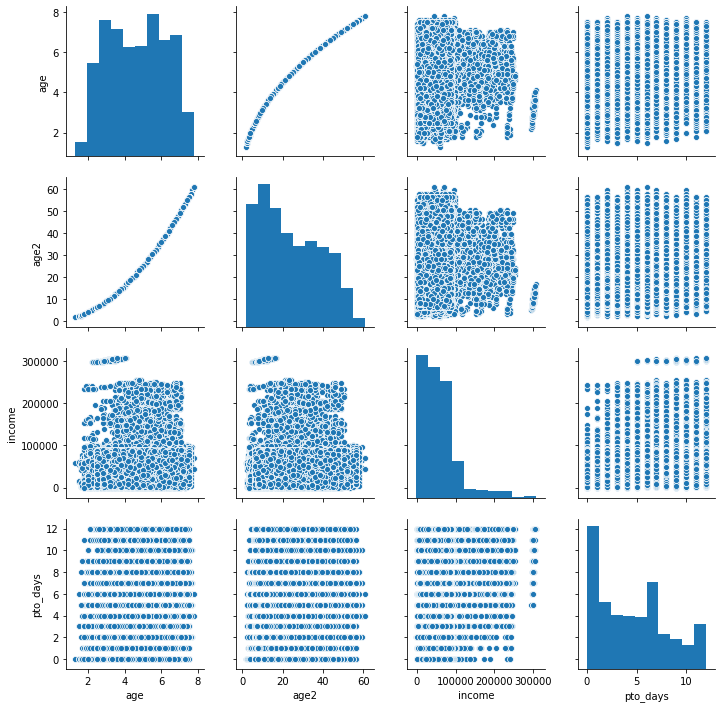

In [10]:
# Pairplots
seaborn.pairplot(features)

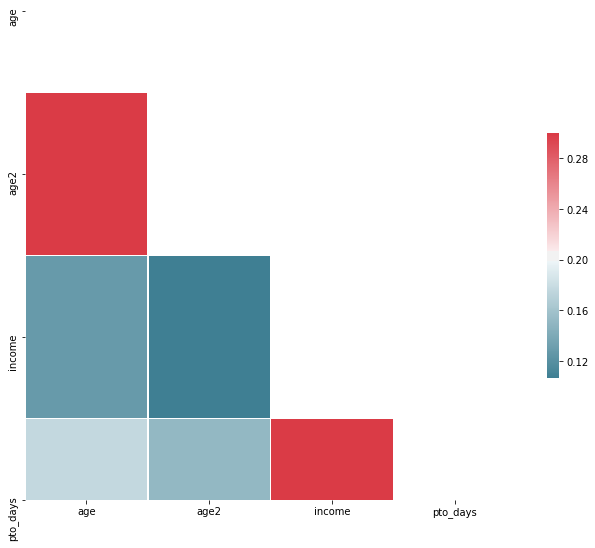

In [11]:
# Compute the correlation matrix
corr = features.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

## Logistic Regression with Bayesian Statistics

In [12]:
# Build GLM binomial model
# This may take some time to run

with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('vacation ~ age + age2 + income + pto_days', 
                            data,
                            family=pm.glm.families.Binomial())
    # sample 1000, 2 chains
    trace = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pto_days, income, age2, age, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [10:17<00:00,  6.48draws/s] 


### Traceplots and Posterior Predictive Plots

In [13]:
# in python's pymc3 library, samples are "traces"
def plot_traces(traces, retain=0):
    ''' 
    Convenience function:
    Plot traces with overlaid means and values
    '''
    
    ax = pm.traceplot(traces[-retain:],
                      lines=tuple([(k, {}, v['mean']) 
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

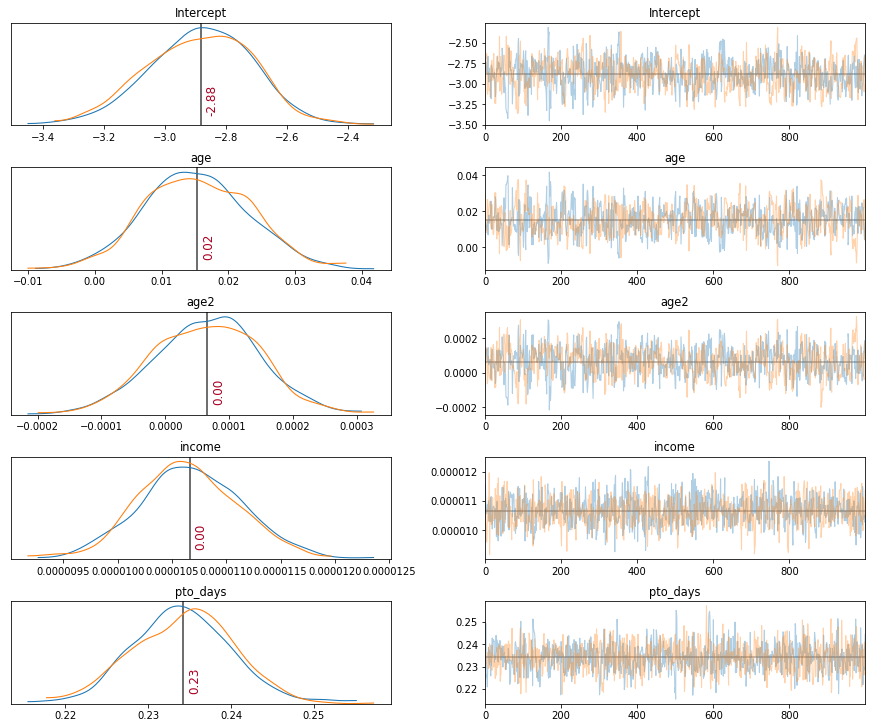

In [14]:
# in python's pymc3 library, samples are "traces"
plot_traces(trace);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The variables, which are vector-valued, produce two histograms and two sample traces, corresponding to predictor coefficients.

<Figure size 648x504 with 0 Axes>

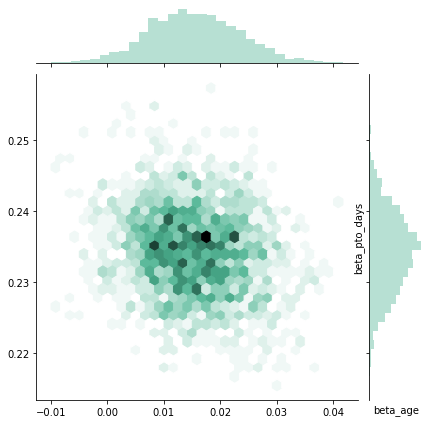

In [15]:
# jointplot between age and pto_days, bivariate relationship
plt.figure(figsize=(9,7))
seaborn.jointplot(trace['age'], trace['pto_days'], kind="hex", color="#4CB391")
plt.xlabel("beta_age")
plt.ylabel("beta_pto_days");

In [16]:
def lm_full(trace, age, income, pto_days):
    shape = np.broadcast(age, income, pto_days).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) 
                         for x in [age/10., income, pto_days]])
    return 1 / (1 + np.exp(-(trace['Intercept'] + 
                             trace['age']*x_norm[0] + 
                             trace['age2']*(x_norm[0]**2) + 
                             trace['income']*x_norm[1] + 
                             trace['pto_days']*x_norm[2])))

# Linear model with income == 60K and pto days == 2
lm1 = lambda x, samples: lm_full(samples, x, 60000.0, 2.0)

# Linear model with income == 60K and pto days == 8
lm2 = lambda x, samples: lm_full(samples, x,  60000.0, 8.0)

# Linear model with income == 60K and pto days == 12
lm3 = lambda x, samples: lm_full(samples, x, 60000.0, 12.0)

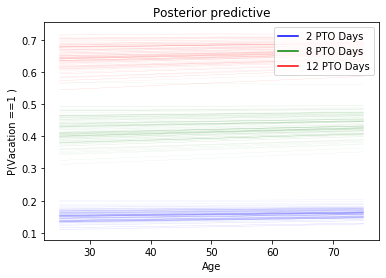

In [17]:
# Plot the posterior predictive distributions of P(vacation ==1) vs. age
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(
    25, 75, 1000), lm=lm1, samples=100, color="blue", alpha=0.15)

pm.plot_posterior_predictive_glm(trace, eval=np.linspace(
    25, 75, 1000), lm=lm2, samples=100, color="green", alpha=0.15)

pm.plot_posterior_predictive_glm(trace, eval=np.linspace(
    25, 75, 1000), lm=lm3, samples=100, color="red", alpha=0.15)



import matplotlib.lines as mlines

blue_line = mlines.Line2D(['lm1'], [], color='b', label='2 PTO Days')
green_line = mlines.Line2D(['lm2'], [], color='g', label='8 PTO Days')
red_line = mlines.Line2D(['lm3'], [], color='r', label='12 PTO Days')


plt.legend(handles=[blue_line, green_line, red_line], loc='upper right')
plt.ylabel("P(Vacation ==1 )")
plt.xlabel("Age")
plt.show()

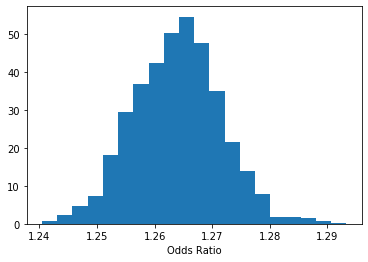

In [18]:
# histogram of odds ratio for pto days
b = trace['pto_days']
plt.hist(np.exp(b), bins=20, normed=True)
plt.xlabel("Odds Ratio")
plt.show()

In [19]:
# credible intervals for Bayesian statistics
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)

print("P(%.3f < O.R. < %.3f) = 0.95" % (np.exp(lb),np.exp(ub)))

P(1.249 < O.R. < 1.279) = 0.95


In [20]:
# end